
# Pure Python Weighted K‑Medoids (PAM) for PTHA Scenario Reduction

This notebook selects **K representative scenarios** (actual medoids) from your
`scenario_pts.txt` and `scenario_prb_wgts.txt` without any extra packages.
It also creates PCA and weight plots and saves `reduced_scenarios_medoids.csv`.


In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

def pairwise_dist(X, Y):
    X2 = np.sum(X**2, axis=1, keepdims=True)
    Y2 = np.sum(Y**2, axis=1, keepdims=True).T
    d2 = X2 + Y2 - 2 * X @ Y.T
    d2 = np.maximum(d2, 0.0)
    return np.sqrt(d2)

def weighted_cost(dist_to_medoids, labels, wgts):
    return np.sum(wgts * dist_to_medoids[np.arange(len(labels)), labels])

def weighted_kmedoids(pts, wgts, k=20, max_iter=100, seed=42):
    rng = np.random.default_rng(seed)
    N = pts.shape[0]
    # init
    medoid_indices = [rng.choice(N, p=wgts)]
    for _ in range(1, k):
        current = pts[medoid_indices]
        d = pairwise_dist(pts, current)
        nearest_d = d.min(axis=1)
        probs = wgts * (nearest_d / (nearest_d.sum() + 1e-12))
        probs = probs / probs.sum()
        medoid_indices.append(rng.choice(N, p=probs))
    medoid_indices = np.array(medoid_indices, dtype=int)

    for it in range(max_iter):
        medoids = pts[medoid_indices]
        D_to_medoids = pairwise_dist(pts, medoids)
        labels = D_to_medoids.argmin(axis=1)
        changed = False
        for m_idx in range(k):
            members = np.where(labels == m_idx)[0]
            if members.size == 0:
                continue
            subD = pairwise_dist(pts[members], pts[members])
            w_sub = wgts[members]
            candidate_costs = subD.T @ w_sub
            best_local_idx = members[np.argmin(candidate_costs)]
            if best_local_idx != medoid_indices[m_idx]:
                medoid_indices[m_idx] = best_local_idx
                changed = True
        if not changed:
            break

    medoids = pts[medoid_indices]
    D_to_medoids = pairwise_dist(pts, medoids)
    labels = D_to_medoids.argmin(axis=1)
    cluster_wgts = np.array([wgts[labels == i].sum() for i in range(k)])
    return medoid_indices, medoids, labels, cluster_wgts


In [8]:

# --- Load inputs ---
pts_path = Path("scenario_pts.txt")
wgts_path = Path("scenario_prb_wgts_new.txt")
assert pts_path.exists() and wgts_path.exists(), "Place scenario_pts.txt and scenario_prb_wgts_new.txt next to this notebook."

pts = np.loadtxt(pts_path.as_posix())
wgts = np.loadtxt(wgts_path.as_posix())
wgts = wgts / np.sum(wgts)

# --- Run weighted K-medoids ---
k = 20  # change as needed
medoid_indices, medoids, labels, cluster_wgts = weighted_kmedoids(pts, wgts, k=k, max_iter=100, seed=42)

# --- Save CSV ---
df = pd.DataFrame(medoids, columns=[f"KL_mode_{i+1}" for i in range(pts.shape[1])])
df["Cluster_Weight"] = cluster_wgts
df["Medoid_Index"] = medoid_indices
df.to_csv("reduced_scenarios_medoids.csv", index=False)
df.head()


,KL_mode_1,KL_mode_2,KL_mode_3,KL_mode_4,KL_mode_5,KL_mode_6,KL_mode_7,KL_mode_8,KL_mode_9,KL_mode_10,...,KL_mode_13,KL_mode_14,KL_mode_15,KL_mode_16,KL_mode_17,KL_mode_18,KL_mode_19,KL_mode_20,Cluster_Weight,Medoid_Index
0,0.505872,-0.352673,-0.135309,0.440005,2.293040,-0.209384,-0.933874,2.205306,2.467884,-2.506245,...,2.099284,-3.483873,-0.299626,2.609632,0.050134,-0.819688,2.760950,1.478448,0.033456,91
1,1.319307,2.006976,0.472922,2.331442,-0.581532,-0.752707,1.427195,-0.616727,0.247399,2.147933,...,-3.106621,-2.362209,2.547963,1.944453,-3.949677,-0.719280,-1.170546,-0.324903,0.000640,64
2,1.527444,-4.609022,2.116396,1.817130,1.307661,-1.245611,0.810836,-1.258455,-1.121381,-1.799029,...,-2.072131,0.388819,-1.168410,0.511576,-0.445912,1.943664,2.533834,-1.094265,0.092906,93
3,-1.089772,0.165688,0.683867,2.415099,-2.483686,-0.982924,0.545233,0.287223,1.447691,-3.422030,...,0.955937,-0.219627,-2.737296,-3.439961,1.148095,1.764042,0.414415,0.918440,0.197017,73
4,-0.812182,0.225713,-2.527951,1.748129,-0.282917,-0.054331,2.134754,-1.053011,1.599752,-3.298070,...,-0.617194,-2.282408,-1.009764,0.127624,-2.302665,2.400294,0.639618,-2.053733,0.029024,4


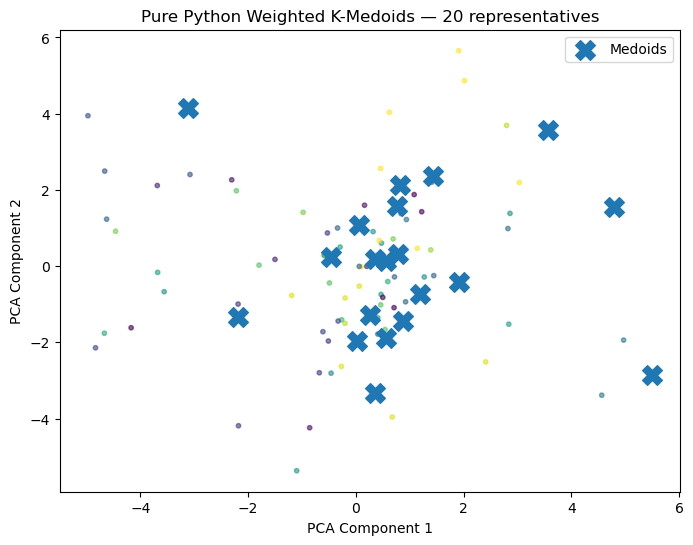

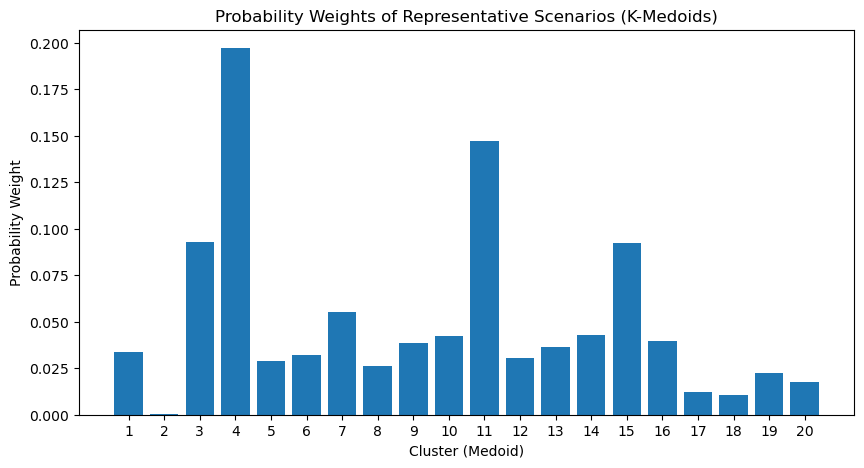

In [9]:

# --- PCA scatter with medoids ---
pca = PCA(n_components=2)
pts_2d = pca.fit_transform(pts)
medoids_2d = pca.transform(medoids)

plt.figure(figsize=(8,6))
plt.scatter(pts_2d[:,0], pts_2d[:,1], c=labels, s=10, alpha=0.6)
plt.scatter(medoids_2d[:,0], medoids_2d[:,1], marker="X", s=200, label="Medoids")
plt.title(f"Pure Python Weighted K-Medoids — {k} representatives")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# --- Bar chart of cluster weights ---
plt.figure(figsize=(10,5))
plt.bar(np.arange(1, k+1), cluster_wgts)
plt.xlabel("Cluster (Medoid)")
plt.ylabel("Probability Weight")
plt.title("Probability Weights of Representative Scenarios (K-Medoids)")
plt.xticks(np.arange(1, k+1))
plt.show()
